In [1]:
import polars as pl
import numpy as np
import gc
import optuna
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

# Load the data

Introduce feature classfications

The absence of a credit history might mean a lot of things, including young age or a preference for cash. Without traditional data, someone with little to no credit history is likely to be denied.

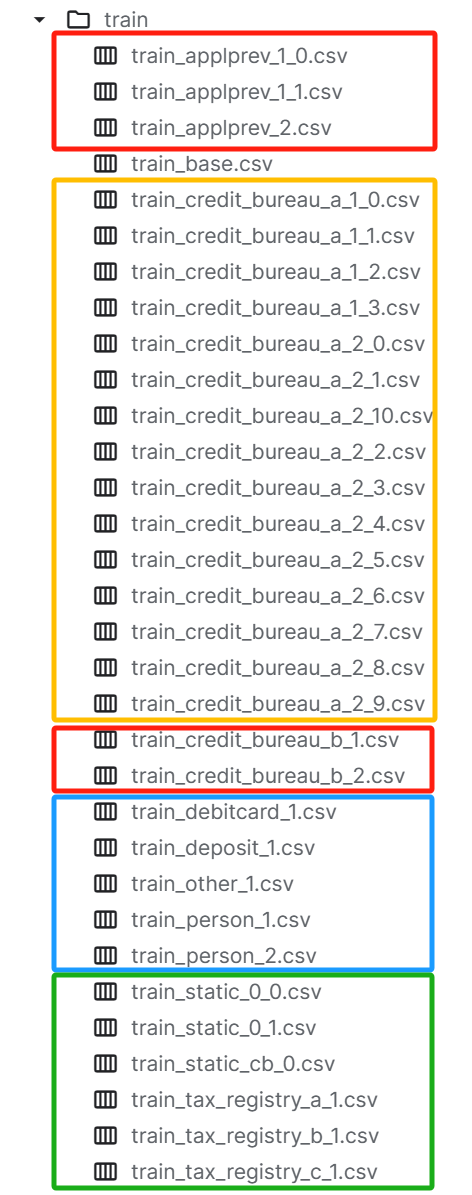

In [9]:
from IPython.display import Image
Image(filename="./feature_classfication.png")

In [11]:
base = pd.read_parquet(f'./train/train_base.parquet')
base

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1
...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0
1526655,2703451,2020-10-05,202010,91,0
1526656,2703452,2020-10-05,202010,91,0
1526657,2703453,2020-10-05,202010,91,0


In [13]:
base['target'].value_counts()

target
0    1478665
1      47994
Name: count, dtype: int64

In [2]:
dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"
# previous applications records
appl1_0 = pl.read_csv(f'{dataPath}csv_files/train/train_applprev_1_0.csv')
appl1_0_test = pl.read_csv(f'{dataPath}csv_files/test/test_applprev_1_0.csv')
appl1_1 = pl.read_csv(f'{dataPath}csv_files/train/train_applprev_1_1.csv')
appl1_1_test = pl.read_csv(f'{dataPath}csv_files/test/test_applprev_1_1.csv')
# credit bereau records
credit1 = pl.read_csv(f'{dataPath}csv_files/train/train_credit_bureau_b_1.csv')
credit1_test = pl.read_csv(f'{dataPath}csv_files/test/test_credit_bureau_b_1.csv')
# case id base
base = pd.read_csv(f'{dataPath}csv_files/train/train_base.csv')
base_test = pd.read_csv(f'{dataPath}csv_files/test/test_base.csv')
# depth = 0 
static_cb = pd.read_csv(f"{dataPath}csv_files/train/train_static_cb_0.csv")
static_cb_test = pd.read_csv(f"{dataPath}csv_files/test/test_static_cb_0.csv")
# depth = 0
static_0_0 = pd.read_csv(f"{dataPath}csv_files/train/train_static_0_0.csv")
static_0_1 = pd.read_csv(f"{dataPath}csv_files/train/train_static_0_1.csv")
static_0_0_test = pd.read_csv(f"{dataPath}csv_files/test/test_static_0_0.csv")
static_0_1_test = pd.read_csv(f"{dataPath}csv_files/test/test_static_0_1.csv")
static_0_2_test = pd.read_csv(f"{dataPath}csv_files/test/test_static_0_2.csv")
# depth = 1
tax_registry_a = pd.read_csv(f"{dataPath}csv_files/train/train_tax_registry_a_1.csv")
tax_registry_b = pd.read_csv(f"{dataPath}csv_files/train/train_tax_registry_b_1.csv")
tax_registry_c = pd.read_csv(f"{dataPath}csv_files/train/train_tax_registry_c_1.csv")
tax_registry_a_test = pd.read_csv(f"{dataPath}csv_files/test/test_tax_registry_a_1.csv")
tax_registry_b_test = pd.read_csv(f"{dataPath}csv_files/test/test_tax_registry_b_1.csv")
tax_registry_c_test = pd.read_csv(f"{dataPath}csv_files/test/test_tax_registry_c_1.csv")

# Process train_credit_bureau_a_1

**Check the maximum days that the last update date is later than decision date for.**

In [1]:
import numpy as np
import gc
import optuna
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
import warnings
warnings.filterwarnings('ignore')

In [2]:
base = pd.read_parquet('./train/train_base.parquet')
base['date_decision'] = pd.to_datetime(base['date_decision'])

In [4]:
train_credit_bureau_a_1_0 = pd.read_parquet(f'./train/train_credit_bureau_a_1_0.parquet')
train_credit_bureau_a_1_0 = train_credit_bureau_a_1_0.merge(base[['case_id', 'date_decision']], on='case_id', how='left')
train_credit_bureau_a_1_0['lastupdate_1112D'] = pd.to_datetime(train_credit_bureau_a_1_0['lastupdate_1112D'])
train_credit_bureau_a_1_0['lastupdate_388D'] = pd.to_datetime(train_credit_bureau_a_1_0['lastupdate_388D'])

(train_credit_bureau_a_1_0.loc[(train_credit_bureau_a_1_0['lastupdate_1112D'] >= train_credit_bureau_a_1_0['date_decision'])\
                                                         | (train_credit_bureau_a_1_0['lastupdate_388D'] >= train_credit_bureau_a_1_0['date_decision']), \
                                  'lastupdate_388D']\
- train_credit_bureau_a_1_0.loc[(train_credit_bureau_a_1_0['lastupdate_1112D'] >= train_credit_bureau_a_1_0['date_decision'])\
                                                         | (train_credit_bureau_a_1_0['lastupdate_388D'] >= train_credit_bureau_a_1_0['date_decision']), \
                                  'date_decision']).max()

Timedelta('14 days 00:00:00')

In [6]:
train_credit_bureau_a_1_0.isna().sum() / len(train_credit_bureau_a_1_0)

case_id                        0.000000
annualeffectiverate_199L       0.990998
annualeffectiverate_63L        0.982392
classificationofcontr_13M      0.000000
classificationofcontr_400M     0.000000
                                 ...   
totaldebtoverduevalue_178A     0.917829
totaldebtoverduevalue_718A     0.927316
totaloutstanddebtvalue_39A     0.917829
totaloutstanddebtvalue_668A    0.927316
date_decision                  0.000000
Length: 80, dtype: float64

In [3]:
# train_credit_bureau_a_1_0 = pd.read_parquet(f'{dataPath}/parquet_files/train/train_credit_bureau_a_1_0.parquet')
# train_credit_bureau_a_1_0 = train_credit_bureau_a_1_0.merge(base[['case_id', 'date_decision']], on='case_id', how='left')
# train_credit_bureau_a_1_0['lastupdate_1112D'] = pd.to_datetime(train_credit_bureau_a_1_0['lastupdate_1112D'])
# train_credit_bureau_a_1_0['lastupdate_388D'] = pd.to_datetime(train_credit_bureau_a_1_0['lastupdate_388D'])

# # (train_credit_bureau_a_1_0.loc[(train_credit_bureau_a_1_0['lastupdate_1112D'] >= train_credit_bureau_a_1_0['date_decision'])\
# #                                                          | (train_credit_bureau_a_1_0['lastupdate_388D'] >= train_credit_bureau_a_1_0['date_decision']), \
# #                                   'lastupdate_388D']\
# # - train_credit_bureau_a_1_0.loc[(train_credit_bureau_a_1_0['lastupdate_1112D'] >= train_credit_bureau_a_1_0['date_decision'])\
# #                                                          | (train_credit_bureau_a_1_0['lastupdate_388D'] >= train_credit_bureau_a_1_0['date_decision']), \
# #                                   'date_decision']).max()

In [4]:
def credit_bureau_a_1_preprocess(credit_bureau_a_1):
    """
    take credit_bureau_a_1 file  as input and aggregate features
    """
#     The last update date is later than decision date for at most 14 days, so leak of future information is not a problem.
#     credit_bureau_a_1 = credit_bureau_a_1.merge(base['date_decision'], left_on='case_id', right_index=True, how='left')
#     credit_bureau_a_1['lastupdate_1112D'] = pd.to_datetime(base['lastupdate_1112D'])
#     credit_bureau_a_1['lastupdate_388D'] = pd.to_datetime(base['lastupdate_388D'])
#     credit_bureau_a_1 = credit_bureau_a_1.loc[(credit_bureau_a_1['lastupdate_1112D'] <= credit_bureau_a_1['date_decision'])\
#                                                          & (credit_bureau_a_1['lastupdate_388D'] <= credit_bureau_a_1['date_decision'])]

#     Sort according to case_id and Date of last update for an active contract.
    credit_bureau_a_1 = credit_bureau_a_1.sort_values(['case_id', 'lastupdate_1112D'])
    credit_bureau_a_1 = credit_bureau_a_1.replace('a55475b1', np.nan)
    credit_bureau_a_1_preprocessed = credit_bureau_a_1.groupby('case_id')[['annualeffectiverate_199L', 'annualeffectiverate_63L']].max()
    credit_bureau_a_1_preprocessed = \
    credit_bureau_a_1_preprocessed.merge(credit_bureau_a_1.groupby('case_id')[['credlmt_230A', 'credlmt_935A']].min(),\
                                              left_index=True, right_index=True, how='outer')
    credit_bureau_a_1_preprocessed = \
    credit_bureau_a_1_preprocessed.merge(credit_bureau_a_1.groupby('case_id')[['debtoutstand_525A', 'debtoverdue_47A']].sum(),\
                                              left_index=True, right_index=True, how='outer')
#     credit_bureau_a_1_preprocessed = \
#     credit_bureau_a_1_preprocessed.merge(credit_bureau_a_1.groupby('case_id')[['description_351M']].last(),\
#                                               left_index=True, right_index=True, how='outer')
    credit_bureau_a_1_preprocessed = \
    credit_bureau_a_1_preprocessed.merge(credit_bureau_a_1.groupby('case_id')[['dpdmax_139P', 'dpdmax_757P', 'dpdmaxdatemonth_442T']].max(),\
                                              left_index=True, right_index=True, how='outer')
    credit_bureau_a_1_preprocessed = \
    credit_bureau_a_1_preprocessed.merge(credit_bureau_a_1.groupby('case_id')[['instlamount_768A']].sum(),\
                                              left_index=True, right_index=True, how='outer')
    credit_bureau_a_1_preprocessed = \
    credit_bureau_a_1_preprocessed.merge(credit_bureau_a_1.groupby('case_id')[['instlamount_852A']].max(),\
                                              left_index=True, right_index=True, how='outer')
    credit_bureau_a_1_preprocessed = \
    credit_bureau_a_1_preprocessed.merge(credit_bureau_a_1.groupby('case_id')[['numberofcontrsvalue_258L','numberofcontrsvalue_358L']].max(),\
                                              left_index=True, right_index=True, how='outer')
    credit_bureau_a_1_preprocessed = \
    credit_bureau_a_1_preprocessed.merge(credit_bureau_a_1.groupby('case_id')[['numberofoverdueinstlmax_1151L','numberofoverdueinstls_725L', 'overdueamountmax_155A', 'overdueamountmax_35A', 'prolongationcount_1120L', 'prolongationcount_599L']].max(),\
                                              left_index=True, right_index=True, how='outer')
    credit_bureau_a_1_preprocessed = \
    credit_bureau_a_1_preprocessed.merge(credit_bureau_a_1.groupby('case_id')[['residualamount_488A','residualamount_856A']].sum(),\
                                              left_index=True, right_index=True, how='outer')
    
    return credit_bureau_a_1_preprocessed

In [5]:
train_credit_bureau_a_1_preprocessed = pd.DataFrame(None)
for x in range(4):
    train_credit_bureau_a_1_x = pd.read_parquet(f'{dataPath}parquet_files/train/train_credit_bureau_a_1_{x}.parquet')
    train_credit_bureau_a_1_x_preprocessed = credit_bureau_a_1_preprocess(train_credit_bureau_a_1_x)
    train_credit_bureau_a_1_preprocessed = pd.concat([train_credit_bureau_a_1_preprocessed, train_credit_bureau_a_1_x_preprocessed], axis=0)

train_credit_bureau_a_1_preprocessed = train_credit_bureau_a_1_preprocessed.reset_index(drop=False)

In [6]:
test_credit_bureau_a_1_preprocessed = pd.DataFrame(None)
for x in range(5):
    test_credit_bureau_a_1_x = pd.read_parquet(f'{dataPath}parquet_files/test/test_credit_bureau_a_1_{x}.parquet')
    test_credit_bureau_a_1_x_preprocessed = credit_bureau_a_1_preprocess(test_credit_bureau_a_1_x)
    test_credit_bureau_a_1_preprocessed = pd.concat([test_credit_bureau_a_1_preprocessed, test_credit_bureau_a_1_x_preprocessed], axis=0)
    
test_credit_bureau_a_1_preprocessed = test_credit_bureau_a_1_preprocessed.reset_index(drop=False)

# Process train_credit_bureau_a_2

In [7]:
def credit_bureau_a_2_preprocess(credit_bureau_a_2):
    """
    take credit_bureau_a_2 file  as input and aggregate features
    """
#     The last update date is later than decision date for at most 14 days, so leak of future information is not a problem.
#     train_credit_bureau_a_1 = train_credit_bureau_a_1.merge(base['date_decision'], left_on='case_id', right_index=True, how='left')
#     train_credit_bureau_a_1['lastupdate_1112D'] = pd.to_datetime(base['lastupdate_1112D'])
#     train_credit_bureau_a_1['lastupdate_388D'] = pd.to_datetime(base['lastupdate_388D'])
#     train_credit_bureau_a_1 = train_credit_bureau_a_1.loc[(train_credit_bureau_a_1['lastupdate_1112D'] <= train_credit_bureau_a_1['date_decision'])\
#                                                          & (train_credit_bureau_a_1['lastupdate_388D'] <= train_credit_bureau_a_1['date_decision'])]

#     Sort according to case_id and Date of last update for an active contract.

    credit_bureau_a_2 = credit_bureau_a_2.replace('a55475b1', np.nan)
    credit_bureau_a_2_preprocessed = credit_bureau_a_2.groupby('case_id')[['collater_valueofguarantee_1124L', 'collater_valueofguarantee_876L']].max()
    credit_bureau_a_2_preprocessed = \
    credit_bureau_a_2_preprocessed.merge(credit_bureau_a_2.groupby('case_id')[['pmts_dpd_1073P', 'pmts_dpd_303P']].max(),\
                                              left_index=True, right_index=True, how='outer')

    return credit_bureau_a_2_preprocessed

In [8]:
train_credit_bureau_a_2_preprocessed = pd.DataFrame(None)
for x in range(11):
    train_credit_bureau_a_2_x = pd.read_parquet(f'{dataPath}parquet_files/train/train_credit_bureau_a_2_{x}.parquet')
    train_credit_bureau_a_2_x_preprocessed = credit_bureau_a_2_preprocess(train_credit_bureau_a_2_x)
    train_credit_bureau_a_2_preprocessed = pd.concat([train_credit_bureau_a_2_preprocessed, train_credit_bureau_a_2_x_preprocessed], axis=0)

train_credit_bureau_a_2_preprocessed = train_credit_bureau_a_2_preprocessed.reset_index(drop=False)

In [9]:
test_credit_bureau_a_2_preprocessed = pd.DataFrame(None)
for x in range(12):
    test_credit_bureau_a_2_x = pd.read_parquet(f'{dataPath}parquet_files/test/test_credit_bureau_a_2_{x}.parquet')
    test_credit_bureau_a_2_x_preprocessed = credit_bureau_a_2_preprocess(test_credit_bureau_a_2_x)
    test_credit_bureau_a_2_preprocessed = pd.concat([test_credit_bureau_a_2_preprocessed, test_credit_bureau_a_2_x_preprocessed], axis=0)

test_credit_bureau_a_2_preprocessed = test_credit_bureau_a_2_preprocessed.reset_index(drop=False)

# Process static_cb, static_0, tax_registry

In [10]:
def process_static_cb(static_cb):
    numerical_cols = [col for col in static_cb if static_cb[col].dtype == np.float64 or static_cb[col].dtype == np.int64]
    return static_cb[numerical_cols]

def process_static_0(static_0):
    static_0 = pd.concat(static_0)
    numerical_cols = [col for col in static_0 if static_0[col].dtype == np.float64 or static_0[col].dtype == np.int64]
    return static_0[numerical_cols]

def process_tax_registry(tax_registry):
    # b和c的case_id无重合
    amount_col = [col for col in tax_registry if 'amount' in col][0]
    name_col = [col for col in tax_registry if 'name' in col][0]
    date_col = [col for col in tax_registry if 'date' in col][0]
    tax_registry[date_col] = pd.to_datetime(tax_registry[date_col])
    firstday = tax_registry.groupby('case_id')[date_col].min()
    tax_registry['firstday'] = tax_registry['case_id'].map(firstday)
    tax_registry['daydiff'] = (tax_registry[date_col] - tax_registry['firstday']).dt.days
    tax_registry_gb = (tax_registry.groupby('case_id')
                       .agg({amount_col: ['sum', 'mean', 'max'],
                            'daydiff': ['mean', 'std', 'max']})
                       .reset_index()
                      )
    tax_registry_gb.columns = ['case_id', f'{amount_col}_sum', f'{amount_col}_mean', f'{amount_col}_max', f'{date_col}_diff_mean', f'{date_col}_diff_std', f'{date_col}_diff_max']
    return tax_registry_gb


static_cb_feats = process_static_cb(static_cb)
static_cb_test_feats = process_static_cb(static_cb_test)
static_cb_test_feats = static_cb_test_feats[[col for col in static_cb_feats]]

static_0_feats = process_static_0([static_0_0, static_0_1])
static_0_test_feats = process_static_0([static_0_0_test, static_0_1_test, static_0_2_test])
static_0_test_feats = static_0_test_feats[[col for col in static_0_feats]]

tax_registry_a_feats = process_tax_registry(tax_registry_a)
tax_registry_b_feats = process_tax_registry(tax_registry_b)
tax_registry_c_feats = process_tax_registry(tax_registry_c)
tax_registry_feats = pd.merge(tax_registry_a_feats, tax_registry_b_feats, on='case_id', how='outer')
tax_registry_feats = pd.merge(tax_registry_feats, tax_registry_c_feats, on='case_id', how='outer')

tax_registry_a_test_feats = process_tax_registry(tax_registry_a_test)
tax_registry_b_test_feats = process_tax_registry(tax_registry_b_test)
tax_registry_c_test_feats = process_tax_registry(tax_registry_c_test)
tax_registry_test_feats = pd.merge(tax_registry_a_test_feats, tax_registry_b_test_feats, on='case_id', how='outer')
tax_registry_test_feats = pd.merge(tax_registry_test_feats, tax_registry_c_test_feats, on='case_id', how='outer')
for col in tax_registry_test_feats:
    if col == 'case_id':
        continue
    tax_registry_test_feats[col] = tax_registry_test_feats[col].astype(np.float64)

# process previous applications data

polars package is much faster than pandas

gc.collect() to save memory

In [11]:
def process_appl_tables(appl1_0, appl1_1):
    appl1 = pl.concat([appl1_0, appl1_1], how="vertical_relaxed")
    # one-hot features
    appl1_one_hot_feat = appl1.sort(['case_id', 'creationdate_885D']).unique(['case_id'])\
            [['credtype_587L', 'education_1138M', 'familystate_726L']]\
            .fill_null('unknown').to_dummies()
    # aggregation features
    appl1_feats = appl1.group_by("case_id").agg(
        pl.col("actualdpd_943P").max().alias("actualdpd_943P_max"),
        pl.col("annuity_853A").max().alias("annuity_853A_max"),
        (pl.col("approvaldate_319D").is_null()==False).sum().alias("any_prev_approval"),
        pl.col("byoccupationinc_3656910L").mean().alias("byoccupationinc_3656910L_mean"),
        pl.col('childnum_21L').max().alias('childnum_21L_max'),
        pl.col('credacc_actualbalance_314A').mean().alias('credacc_actualbalance_314A_mean'),
        pl.col('credacc_credlmt_575A').max().alias('credacc_credlmt_575A_max'),
        pl.col('credamount_590A').max().alias('credamount_590A_max'),
        pl.col('currdebt_94A').max().alias('currdebt_94A_max'),
        pl.col('downpmt_134A').max().alias('downpmt_134A_max'),
        (pl.col("dtlastpmt_581D").is_null()==False).any().alias("any_dtlastpmt"),
        pl.col('mainoccupationinc_437A').mean().alias('mainoccupationinc_437A_mean'),
        pl.col('outstandingdebt_522A').max().alias('outstandingdebt_522A_max'),
    ).sort(['case_id'])
    appl1_feats = pl.concat([appl1_feats, appl1_one_hot_feat], how="horizontal").fill_null(-1)
    return appl1_feats

train_appl_feats = process_appl_tables(appl1_0, appl1_1).to_pandas()
test_appl_feats = process_appl_tables(appl1_0_test, appl1_1_test).to_pandas()
missing_columns = [col for col in train_appl_feats.columns if col not in test_appl_feats.columns]
test_appl_feats[missing_columns] = 0
test_appl_feats = test_appl_feats[train_appl_feats.columns].fillna(-1)
print(train_appl_feats.shape, test_appl_feats.shape)
# collect to save memory
del appl1_0, appl1_1, appl1_0_test, appl1_1_test
gc.collect()

(1221522, 30) (2, 30)


30

# process credit bereau records

In [12]:
def process_credit_tables(credit1):
    one_hot_cols = ['pmtmethod_731M']
    credit1_one_hot_feat = credit1.sort(['case_id', 'contractdate_551D']).unique(['case_id'])\
            [one_hot_cols].fill_null('unknown').to_dummies()
    credit1_feats = credit1.sort(['case_id', 'num_group1']).group_by("case_id").agg(
        pl.col("amount_1115A").mean().alias("amount_1115A_mean"),
        pl.col('credlmt_1052A').sum().alias('credlmt_1052A_sum'),
        pl.col('credlmt_3940954A').max().alias('credlmt_3940954A_max'),
        pl.col('credquantity_1099L').max().alias('credquantity_1099L_max'),
        pl.col('debtpastduevalue_732A').sum().alias('debtpastduevalue_732A_sum'),
        pl.col('debtvalue_227A').sum().alias('debtvalue_227A_sum'),
        pl.col('dpd_550P').max().alias('dpd_550P_max'),
        pl.col('dpdmax_851P').max().alias('dpdmax_851P_max'),
        pl.col('installmentamount_644A').max().alias('installmentamount_644A_max'),
        pl.col('installmentamount_833A').max().alias('installmentamount_833A_max'),
        pl.col('instlamount_892A').max().alias('instlamount_892A_max'),
        pl.col('interesteffectiverate_369L').max().alias('interesteffectiverate_369L_max'),
        pl.col('interestrateyearly_538L').max().alias('interestrateyearly_538L_max'),
        pl.col('maxdebtpduevalodued_3940955A').max().alias('maxdebtpduevalodued_3940955A_max'),
        pl.col('numberofinstls_810L').max().alias('numberofinstls_810L_max'),
        pl.col('overdueamountmax_950A').max().alias('overdueamountmax_950A_max'),
        pl.col('pmtdaysoverdue_1135P').max().alias('pmtdaysoverdue_1135P_max'),
        pl.col('pmtnumpending_403L').max().alias('pmtnumpending_403L_max'),
        pl.col('residualamount_1093A').sum().alias('residualamount_1093A_sum'),
        pl.col('residualamount_127A').sum().alias('residualamount_127A_sum'),
        pl.col('residualamount_3940956A').sum().alias('residualamount_3940956A_sum'),
        pl.col('totalamount_503A').sum().alias('totalamount_503A_sum'),
        pl.col('totalamount_881A').sum().alias('totalamount_881A_sum'),
    ).sort(['case_id'])
    credit1_feats = pl.concat([credit1_feats, credit1_one_hot_feat], how="horizontal").fill_null(-1)
    return credit1_feats
train_credit1_feats = process_credit_tables(credit1).to_pandas()
test_credit1_feats = process_credit_tables(credit1_test).to_pandas()
missing_columns = [col for col in train_credit1_feats.columns if col not in test_credit1_feats.columns]
test_credit1_feats[missing_columns] = 0
test_credit1_feats = test_credit1_feats[train_credit1_feats.columns]
print(train_credit1_feats.shape, test_credit1_feats.shape)
del credit1, credit1_test
gc.collect()

(36500, 32) (3, 32)


0

# Modelling

In the modelling part, so far we only tried **a lgbm model** as our benchmark.

**train valid split**
= 4: 1

In [13]:
def data_for_training(data_feats):
    # train valid split
    def get_train_valid(data, case_ids):
        return (
            data[data["case_id"].isin(case_ids)][["case_id", "WEEK_NUM", "target"]],
            data[data["case_id"].isin(case_ids)][data.columns[5:]],
            data[data["case_id"].isin(case_ids)]["target"]
        )
    data = base.merge(data_feats, how="inner", on="case_id")
    case_ids = data["case_id"].unique()
    case_ids_train, case_ids_valid = train_test_split(case_ids, train_size=0.8, random_state=1)
    base_train, X_train, y_train = get_train_valid(data, case_ids_train)
    base_valid, X_valid, y_valid = get_train_valid(data, case_ids_valid)
    print(f"Train: {X_train.shape}")
    print(f"Valid: {X_valid.shape}")
    return base_train, X_train, y_train, base_valid, X_valid, y_valid

**Tuning the parameters**: 

Set a range of paramters, trial numbers and target score. Use Optuna to find the optimal parameters.

For each trainning, use early stopping.

The early stopping metric and the target score are both chosen to be auc.

In [14]:
def train_lgbm_model_with_optuna(X_train, y_train, X_valid, y_valid):
    
    def objective(trial):
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'metric': 'auc',
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
            'n_estimators': 10000,
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            "seed": 42
        }
        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=lgb_valid,
            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(100)]
        )
        predictions = gbm.predict(X_valid)
        score = roc_auc_score(y_valid, predictions)
        return score
    
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    best_params = study.best_params
    gbm = lgb.train(
            best_params,
            lgb_train,
            valid_sets=lgb_valid,
            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(100)]
    )
    print(f"Best Hyperparameters: {best_params}")
    return gbm

An interface for trianing or testing a model

In [15]:
def set_and_eval_model(train_feats, test_feats, description, is_trained=False, model_path=''):
    # train valid
    base_train, X_train, y_train, base_valid, X_valid, y_valid = data_for_training(train_feats)
    # test
    test_case_id, X_test = test_feats.iloc[:, [0]], test_feats.iloc[:, 1:]
    # train model
    if not is_trained:
        model = train_lgbm_model_with_optuna(X_train, y_train, X_valid, y_valid)
        model.save_model('./lgb_model_%s.txt'%description, num_iteration=model.best_iteration)
    else:
        model = lgb.Booster(model_file=model_path)
    # get result
    for res_df, X in [(base_train, X_train), (base_valid, X_valid), (test_case_id, X_test)]:
        y_pred = model.predict(X, num_iteration=model.best_iteration)
        res_df["%s_score"%description] = y_pred
    print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["%s_score"%description])}') 
    print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["%s_score"%description])}') 
    return test_case_id

# Eval Models

So far, we have examined 7 types of tables so that we have 7 individual models.

For each model belongs to a specific table, it only predicts the case id that occurs in the corresponding test table.

static_cb model

In [17]:
# train and save model
# static_cb_test_case_id = set_and_eval_model(static_cb_feats, static_cb_test_feats, description='static_cb')

# read from the trained model and evaluate it
static_cb_test_case_id = set_and_eval_model(static_cb_feats, static_cb_test_feats, 'static_cb', True, '/kaggle/input/homecreditdataset/lgb_model_static_cb.txt')
static_cb_test_case_id

Train: (1200380, 36)
Valid: (300096, 36)
The AUC score on the train set is: 0.6715037805707027
The AUC score on the valid set is: 0.6667523764911139


,case_id,static_cb_score
0,57543,0.030519
1,57549,0.061941
2,57551,0.026358
3,57552,0.019277
4,57569,0.038221
5,57630,0.024890
6,57631,0.022029
7,57632,0.019277
8,57633,0.036148
9,57634,0.024996


static_0 model

In [18]:
# static_0_test_case_id = set_and_eval_model(static_0_feats, static_0_test_feats, description='static_0')
static_0_test_case_id = set_and_eval_model(static_0_feats, static_0_test_feats, 'static_0', True, '/kaggle/input/homecreditdataset/lgb_model_static_0.txt')
static_0_test_case_id

Train: (1221327, 128)
Valid: (305332, 128)
The AUC score on the train set is: 0.7601849626034975
The AUC score on the valid set is: 0.7522551101656807


,case_id,static_0_score
0,57543,0.031393
1,57551,0.024228
2,57552,0.029416
3,57569,0.075240
4,57630,0.023043
5,57631,0.042750
6,57632,0.015937
7,57635,0.038557
8,57637,0.020564
9,57639,0.026702


tax_registry mode

In [20]:
# tax_registry_test_case_id = set_and_eval_model(tax_registry_feats, tax_registry_test_feats, description='tax_registry')
tax_registry_test_case_id = set_and_eval_model(tax_registry_feats, tax_registry_test_feats, 'tax_registry', True, '/kaggle/input/homecreditdataset/lgb_model_tax_registry.txt')
tax_registry_test_case_id

Train: (803012, 18)
Valid: (200753, 18)
The AUC score on the train set is: 0.6351437818277852
The AUC score on the valid set is: 0.6149956308268533


,case_id,tax_registry_score
0,57675,0.031738
1,57754,0.045048
2,57543,0.026826
3,57551,0.038264


credit_bureau_a_1 model

In [21]:
# # 训练并保存模型
# cb1_test_case_id = set_and_eval_model(train_credit_bureau_a_1_preprocessed, test_credit_bureau_a_1_preprocessed, description='credit_bureau_a_1')

# 调用保存好的模型
cb1_test_case_id = set_and_eval_model(train_credit_bureau_a_1_preprocessed, test_credit_bureau_a_1_preprocessed, 'credit_bureau_a_1', True, '/kaggle/input/homecreditdataset/lgb_model_credit_bureau_a_1.txt')
cb1_test_case_id

Train: (1109018, 21)
Valid: (277255, 21)
The AUC score on the train set is: 0.7568124552762198
The AUC score on the valid set is: 0.75305884494789


,case_id,credit_bureau_a_1_score
0,57551,0.022467
1,57543,0.024180
2,57633,0.022739
3,57549,0.048587
4,57760,0.043118


credit_bureau_a_2 model

In [22]:
# 训练并保存模型
# cb2_test_case_id = set_and_eval_model(train_credit_bureau_a_2_preprocessed, test_credit_bureau_a_2_preprocessed, description='credit_bureau_a_2')

# 调用保存好的模型
cb2_test_case_id = set_and_eval_model(train_credit_bureau_a_2_preprocessed, test_credit_bureau_a_2_preprocessed, 'credit_bureau_a_2', True, '/kaggle/input/homecreditdataset/lgb_model_credit_bureau_a_2.txt')
cb2_test_case_id

Train: (78642, 4)
Valid: (19661, 4)
The AUC score on the train set is: 0.6528037966520233
The AUC score on the valid set is: 0.6559061198761413


,case_id,credit_bureau_a_2_score
0,57551,0.023761
1,57631,0.020411
2,57632,0.025098
3,57543,0.025881
4,57630,0.020411
5,57569,0.062709
6,57636,0.024054
7,57633,0.015493
8,57645,0.027160
9,57549,0.027160


credit model

In [23]:
# 训练并保存模型
# credit_test_case_id = set_and_eval_model(train_credit1_feats, test_credit1_feats, description='credit')

# 调用保存好的模型
credit_test_case_id = set_and_eval_model(train_credit1_feats, test_credit1_feats, 'credit', True, '/kaggle/input/homecreditdataset/lgb_model_credit.txt')
credit_test_case_id

Train: (29200, 31)
Valid: (7300, 31)
The AUC score on the train set is: 0.7952779058269245
The AUC score on the valid set is: 0.7181494293286905


,case_id,credit_score
0,57675,0.061790
1,57754,0.046216
2,57775,0.060493


appl model

In [24]:
# 训练并保存模型
# appl_test_case_id = set_and_eval_model(train_appl_feats, test_appl_feats, description='applications')

# 调用保存好的模型
appl_test_case_id = set_and_eval_model(train_appl_feats, test_appl_feats, 'applications', True, '/kaggle/input/homecreditdataset/lgb_model_applications.txt')
appl_test_case_id

Train: (977217, 29)
Valid: (244305, 29)
The AUC score on the train set is: 0.6571780937090161
The AUC score on the valid set is: 0.6421839741141211


,case_id,applications_score
0,57543,0.029235
1,57549,0.030704


# Ensembling

As mentioned, some case ids may only belongs to a part range of test tables.

The need to construct a model for each table.

In [25]:
score = pd.concat(
    [base_test.set_index('case_id'),
    appl_test_case_id.set_index('case_id'),
    credit_test_case_id.set_index('case_id'),
    cb1_test_case_id.set_index('case_id'),
    cb2_test_case_id.set_index('case_id'),
    static_cb_test_case_id.set_index('case_id'),
    static_0_test_case_id.set_index('case_id'),
    tax_registry_test_case_id.set_index('case_id')],
    axis=1)
score

,date_decision,MONTH,WEEK_NUM,applications_score,credit_score,credit_bureau_a_1_score,credit_bureau_a_2_score,static_cb_score,static_0_score,tax_registry_score
case_id,,,,,,,,,,
57543,2021-05-14,202201.0,100.0,0.029235,NaN,0.024180,0.025881,0.030519,0.031393,0.026826
57549,2022-01-17,202201.0,100.0,0.030704,NaN,0.048587,0.027160,0.061941,0.029161,NaN
57551,2020-11-27,202201.0,100.0,NaN,NaN,0.022467,0.023761,0.026358,0.024228,0.038264
57552,2020-11-27,202201.0,100.0,NaN,NaN,NaN,NaN,0.019277,0.029416,NaN
57569,2021-12-20,202201.0,100.0,NaN,NaN,NaN,0.062709,0.038221,0.075240,NaN
57630,2021-03-16,202201.0,100.0,NaN,NaN,NaN,0.020411,0.024890,0.023043,NaN
57631,2022-06-04,202201.0,100.0,NaN,NaN,NaN,0.020411,0.022029,0.042750,NaN
57632,2022-02-05,202201.0,100.0,NaN,NaN,NaN,0.025098,0.019277,0.015937,NaN
57633,2022-01-25,202201.0,100.0,NaN,NaN,0.022739,0.015493,0.036148,0.032310,NaN


As benchmark, we only takes equal weightes for each model

In [29]:
submission = score.reset_index().iloc[:10, [0]]
submission['score'] = score.iloc[:10, 4:].mean(axis=1).reset_index(drop=True)
submission.to_csv('/kaggle/working/submission.csv', index=False)
submission

,case_id,score
0,57543,0.027760
1,57549,0.041712
2,57551,0.027016
3,57552,0.024347
4,57569,0.058723
5,57630,0.022782
6,57631,0.028397
7,57632,0.020104
8,57633,0.026673
9,57634,0.022553


# Future Works

1. label imbalance: very small default cases

2. incoporating more models: for those tables with larger dataset, NN models could be a try

3. feature scaling: it is a tree model so we ignore feature scaling

4. different ensembling methods: assign weightes by model performance

In [ ]:
# def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
#     gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
#         .sort_values("WEEK_NUM")\
#         .groupby("WEEK_NUM")[["target", "score"]]\
#         .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
#     x = np.arange(len(gini_in_time))
#     y = gini_in_time
#     a, b = np.polyfit(x, y, 1)
#     y_hat = a*x + b
#     residuals = y - y_hat
#     res_std = np.std(residuals)
#     avg_gini = np.mean(gini_in_time)
#     return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

# stability_score_train = gini_stability(base_train)
# stability_score_valid = gini_stability(base_valid)
# stability_score_test = gini_stability(base_test)

# print(f'The stability score on the train set is: {stability_score_train}') 
# print(f'The stability score on the valid set is: {stability_score_valid}') 
# print(f'The stability score on the test set is: {stability_score_test}')  

In [ ]:
# X_submission = data_submission[cols_pred].to_pandas()
# X_submission = convert_strings(X_submission)
# categorical_cols = X_train.select_dtypes(include=['category']).columns

# for col in categorical_cols:
#     train_categories = set(X_train[col].cat.categories)
#     submission_categories = set(X_submission[col].cat.categories)
#     new_categories = submission_categories - train_categories
#     X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
#     new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
#     X_train[col] = X_train[col].astype(new_dtype)
#     X_submission[col] = X_submission[col].astype(new_dtype)

# y_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration)

In [ ]:
# submission = pd.DataFrame({
#     "case_id": data_submission["case_id"].to_numpy(),
#     "score": y_submission_pred
# }).set_index('case_id')
# submission.to_csv("./submission.csv")